Progressive resizing is a strategy which can be used to reduce computation time in order to allow more parameter tuning. This CNN model is from kaggle which I am using just to observe the difference in run time and performance using progressive resizing.
https://www.kaggle.com/plubinski/retinal-separableconv2d-99-validation

In [1]:
#Import all necessary packages
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob

import pydot_ng as pydot
seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
#Find directory name for where images are located
os.path.dirname(r"C:\Users\Christian\Pictures\OCT2017\test")

'C:\\Users\\Christian\\Pictures\\OCT2017'

In [3]:
#Establishing and setting paths for all image data subsets
#Set directory names for all images
dirname = r'C:\\Users\\Christian\\Pictures\\OCT2017'
#define training path
train_path = os.path.join(dirname, r"C:\Users\Christian\Pictures\OCT2017\train")
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')

#Define Test Path
test_path = os.path.join(dirname, r"C:\Users\Christian\Pictures\OCT2017\test")
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')

#Define Validation Path
val_path = os.path.join(dirname, r"C:\Users\Christian\Pictures\OCT2017\val")
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')

In [4]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 4, idx+1)

        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

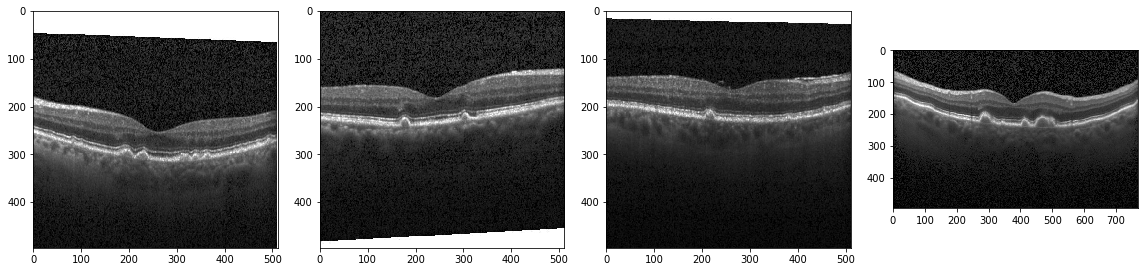

In [5]:
plot_imgs(val_drusen_pth)

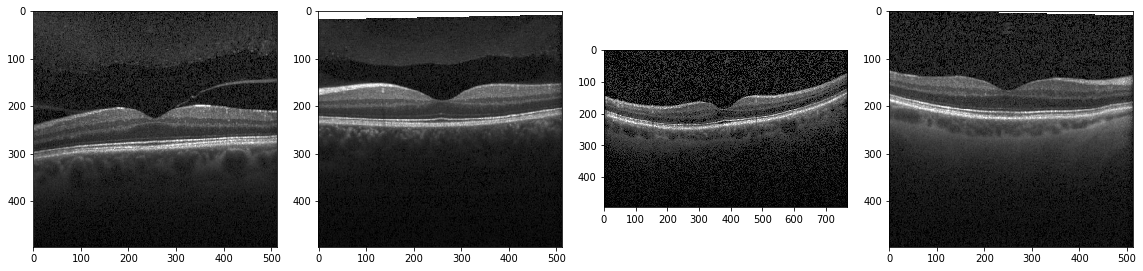

In [6]:
plot_imgs(test_normal_pth)

In [7]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [36]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True)
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (48, 48), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=test_path, 
    target_size=(48, 48), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/DME/':
                label = 1
            elif cond=='/DRUSEN/':
                label = 2
            elif cond=='/CNV/':
                label = 3
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [42]:
PARAMS = {'img_dims': 48,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }

In [43]:
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=4, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [44]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 48, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
separable_conv2d_24 (Separab (None, 24, 24, 32)        688       
_________________________________________________________________
separable_conv2d_25 (Separab (None, 24, 24, 32)        1344      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 32)        128 

In [45]:
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
           
           validation_data=test_gen, 
           validation_steps=test_gen.samples // PARAMS['batch_size'],
           callbacks=[checkpoint, lr_reduce])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2608 steps, validate for 30 steps
Epoch 1/10
2608/2608 [==============================] - 1619s 621ms/step - loss: 0.8099 - accuracy: 0.6935 - val_loss: 1.3135 - val_accuracy: 0.5000
Epoch 2/10
2608/2608 [==============================] - 1734s 665ms/step - loss: 0.6618 - accuracy: 0.7641 - val_loss: 1.0840 - val_accuracy: 0.6073
Epoch 3/10
2607/2608 [============================>.] - ETA: 0s - loss: 0.5886 - accuracy: 0.7882
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2608/2608 [==============================] - 1854s 711ms/step - loss: 0.5887 - accuracy: 0.7882 - val_loss: 0.4794 - val_accuracy: 0.7958
Epoch 4/10
2608/2608 [==============================] - 1152s 442ms/step - loss: 0.5142 - accuracy: 0.8146 - val_loss: 0.3945 - val_accuracy: 0.8417
Epoch 5/10
2607/2608 [============================>.] - ETA: 0s - loss: 0.4911 - accuracy: 0.8237
Epoch 00005: ReduceLROnPlateau reducing learn

In [46]:
print ('Train Accuracy', np.mean(history.history['accuracy']))
print ('Train Loss', np.mean(history.history['loss']))
print ('Test Accuracy', np.mean(history.history['val_accuracy']))
print ('Test Loss', np.mean(history.history['val_loss']))

Train Accuracy 0.8075517
Train Loss 0.5319190836217599
Test Accuracy 0.805
Test Loss 0.5147706091155608


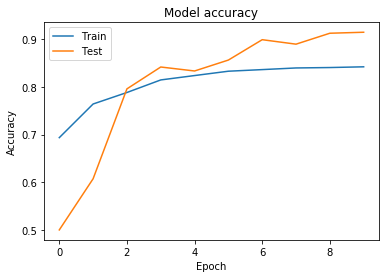

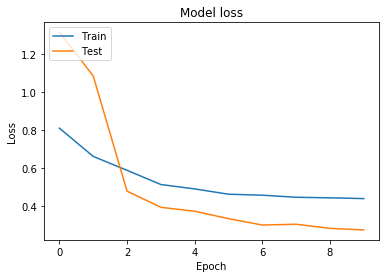

In [47]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()